# Dealing with outliers
- Look for the Outliers. Fix them if needed, using a couple of techniques before deciding which is best.

Identifying outliers in 'property_type', 'is_new', 'duration', and 'ppdcategory_type'

In [1]:
# Import
import pyarrow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import dates
from scipy.stats import gaussian_kde
import seaborn as sns

In [2]:
# Load
df = pd.read_parquet('data/initial_cleaning.parquet', engine='pyarrow')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22489348 entries, 0 to 22489347
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   price             int64         
 1   date_of_transfer  datetime64[ns]
 2   property_type     object        
 3   is_new            bool          
 4   duration          object        
 5   city              object        
 6   district          object        
 7   county            object        
 8   ppdcategory_type  object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(6)
memory usage: 1.4+ GB


# Is new

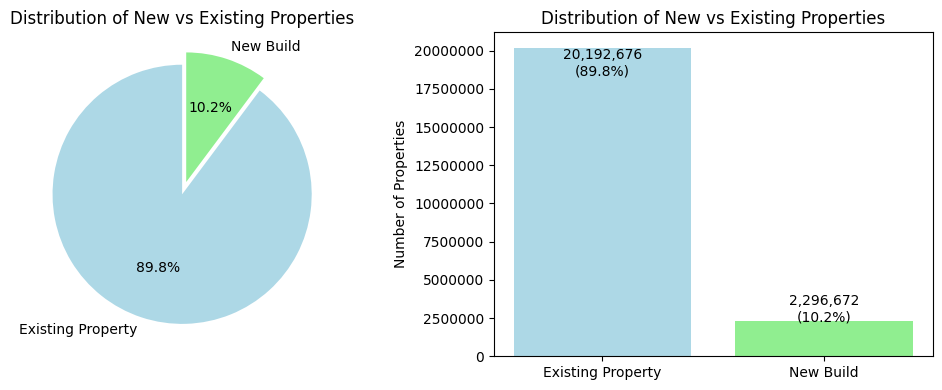

In [ ]:
# Distribution of 'is_new'
plt.figure(figsize=(10, 4))

# Pie chart
plt.subplot(1, 2, 1)
is_new_counts = df['is_new'].value_counts()
plt.pie(is_new_counts,
       labels=['Existing Property', 'New Build'] if is_new_counts.index.tolist() == [0, 1] else ['New Build', 'Existing Property'],
       colors=['lightblue', 'lightgreen'],
       autopct='%1.1f%%',
       startangle=90,
       explode=(0, 0.1))
plt.title('Distribution of New vs Existing Properties')

# Bar Chart
plt.subplot(1, 2, 2)
labels = ['Existing Property', 'New Build'] if is_new_counts.index.tolist() == [0, 1] else ['New Build', 'Existing Property']
plt.bar(labels, is_new_counts.values, color=['lightblue', 'lightgreen'])
plt.title('Distribution of New vs Existing Properties')
plt.ylabel('Number of Properties')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# Add value labels on top of bars
for i, v in enumerate(is_new_counts.values):
   plt.text(i, v*0.9, f'{v:,}\n({v/sum(is_new_counts.values)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()


'is_new' is a imbalanced column

# Duration

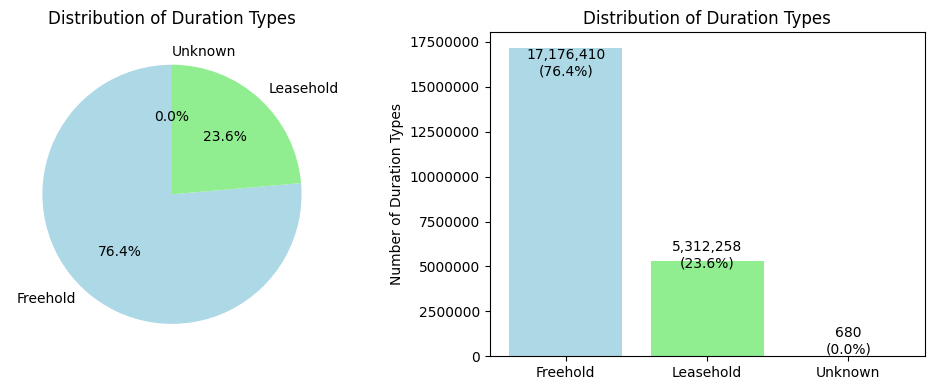

In [11]:
# Distribution of 'duration'
plt.figure(figsize=(10,4))

# Pie chart
plt.subplot(1, 2, 1)
duration_counts = df['duration'].value_counts()
labels_duration = {
   'F': 'Freehold',
   'L': 'Leasehold',
   'U': 'Unknown'
}
plt.pie(duration_counts,
       labels=[labels_duration[x] for x in duration_counts.index],
       colors=['lightblue', 'lightgreen', 'red'],
       autopct='%1.1f%%',
       startangle=90)
plt.title('Distribution of Duration Types')

# Bar Chart
plt.subplot(1, 2, 2)
labels = [labels_duration[x] for x in duration_counts.index]
plt.bar(labels, duration_counts.values, color=['lightblue', 'lightgreen', 'red'])
plt.title('Distribution of Duration Types')
plt.ylabel('Number of Duration Types')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# Add value labels on top of bars
for i, v in enumerate(duration_counts.values):
   plt.text(i, v*0.9, f'{v:,}\n({v/sum(duration_counts.values)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [6]:
print('With outliers:', len(df))

outliers_df = df[~(df['duration'] == 'U')]

print('Without outliers:', len(outliers_df))

With outliers: 22489348
Without outliers: 22488668


'duration' is a imbalanced column.

It also contains value 'U' representing Unknown which takes 0.0% out of all the data. I decided to drop the rows containing 'U' since it is a small portion of the dataset and might confuse the prediction.

# Property type

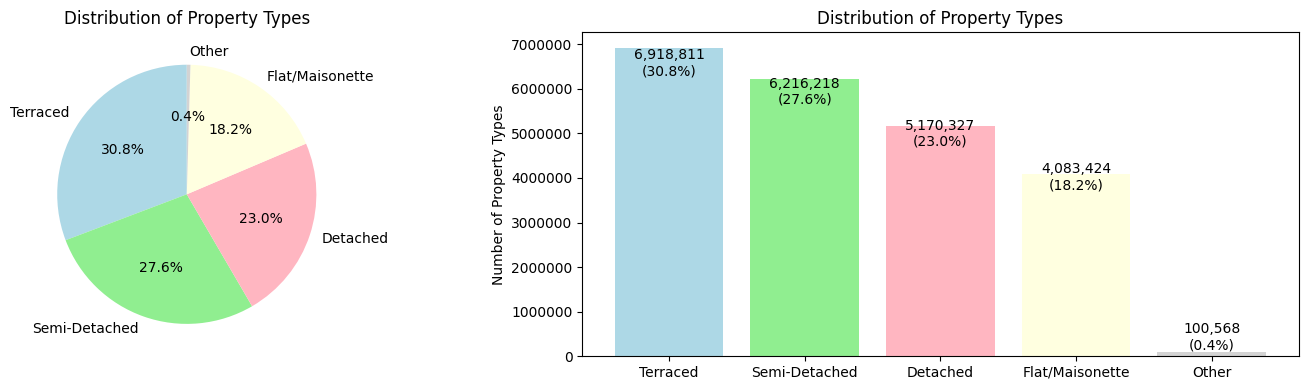

In [13]:
# Distribution of 'property_type'
plt.figure(figsize=(15, 4))

# Pie chart
plt.subplot(1, 2, 1)
property_counts = df['property_type'].value_counts()
labels_property = {
   'T': 'Terraced',
   'S': 'Semi-Detached',
   'D': 'Detached',
   'F': 'Flat/Maisonette',
   'O': 'Other'
}
plt.pie(property_counts, 
       labels=[labels_property[x] for x in property_counts.index],
       colors=['lightblue', 'lightgreen', 'lightpink', 'lightyellow', 'lightgray'],
       autopct='%1.1f%%',
       startangle=90)
plt.title('Distribution of Property Types')

# Bar Chart
plt.subplot(1, 2, 2)
labels = [labels_property[x] for x in property_counts.index]
plt.bar(labels, property_counts.values, color=['lightblue', 'lightgreen', 'lightpink', 'lightyellow', 'lightgray'])
plt.title('Distribution of Property Types')
plt.ylabel('Number of Property Types')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# Add value labels on top of bars
for i, v in enumerate(property_counts.values):
   plt.text(i, v*0.9, f'{v:,}\n({v/sum(property_counts.values)*100:.1f}%)', ha='center', va='bottom')


plt.tight_layout()
plt.show()

# PPD Category

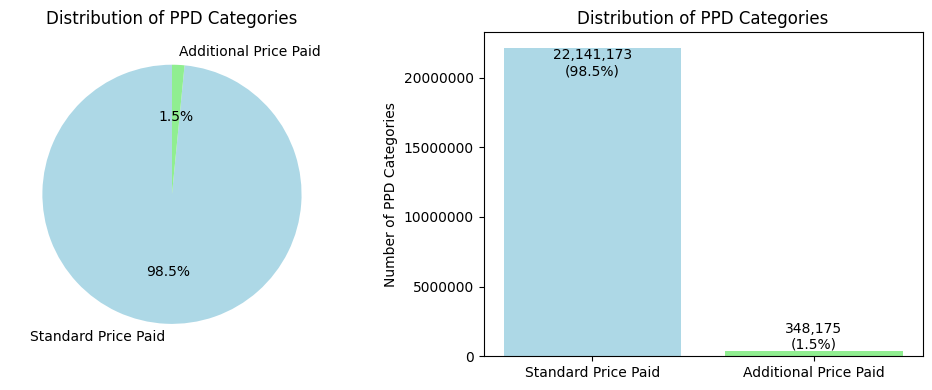

In [14]:

# Distribution of 'ppdcategory_type'
plt.figure(figsize=(10, 4))

# Pie chart
plt.subplot(1, 2, 1)
ppd_counts = df['ppdcategory_type'].value_counts()
labels_ppd = {
   'A': 'Standard Price Paid',
   'B': 'Additional Price Paid'
}
plt.pie(ppd_counts,
       labels=[labels_ppd[x] for x in ppd_counts.index],
       colors=['lightblue', 'lightgreen'],
       autopct='%1.1f%%',
       startangle=90)
plt.title('Distribution of PPD Categories')

# Bar Chart
plt.subplot(1, 2, 2)
labels = [labels_ppd[x] for x in ppd_counts.index]
plt.bar(labels, ppd_counts.values, color=['lightblue', 'lightgreen'])
plt.title('Distribution of PPD Categories')
plt.ylabel('Number of PPD Categories')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# Add value labels on top of bars
for i, v in enumerate(ppd_counts.values):
   plt.text(i, v*0.9, f'{v:,}\n({v/sum(ppd_counts.values)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

'ppdcategory_type' is a imbalanced column

In [9]:
# Save data in parquet format
outliers_df = outliers_df.reset_index(drop=True)
print(outliers_df.info())
outliers_df.to_parquet('data/outliers.parquet', engine='pyarrow')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22488668 entries, 0 to 22488667
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   price             int64         
 1   date_of_transfer  datetime64[ns]
 2   property_type     object        
 3   is_new            bool          
 4   duration          object        
 5   city              object        
 6   district          object        
 7   county            object        
 8   ppdcategory_type  object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(6)
memory usage: 1.4+ GB
None
